In [1]:
import sys
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
from functools import wraps

In [2]:
import base64
import time
from volcenginesdkarkruntime import Ark
import sounddevice as sd
import soundfile as sf

In [ ]:
import base64
import os
from volcenginesdkarkruntime import Ark

In [ ]:
from dotenv import load_dotenv
load_dotenv()  # 加载.env文件，其中api_key写在了根目录的.env文件中

# class 1:
实现一个类装饰器ImageHSV，其计算图像进行预处理前图像的大小、亮度和饱和度，并输出到特定的日志文件中。
可以使用OpenCV库来计算图像的大小、亮度和饱和度，如可将图像颜色空间转换为HSV格式，然后计算亮度和饱和度的均值

In [4]:
class ImageHSV:
    def __init__(self,func):
        self.func = func
    def __call__(self,file_path):
        print(f'开始读取图片信息：{file_path}')
        
        img=cv.imread(file_path)
        height, width, channels = img.shape
        print(f'height:{height},width:{width},channels:{channels}')
        
        #转化为hsv
        hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
        h,s,v = cv.split(hsv)
        
        #display
        plt.subplot(2,2,1)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2HSV))
        plt.show()
        #计算亮度和饱和度
        average_h= np.mean(h)
        average_s= np.mean(s)
        average_v= np.mean(v) 
        print(f'hue:{average_h},saturation:{average_s},value:{average_v}')
        
        result = self.func(file_path)
        print(f'读取完毕：{file_path}')
        return result

# function:
实现一个**函数装饰器img_resizer**，其能够对返回读取并返回图片的其他函数进行装饰，目的是将所返回的图片压缩到特定的大小。
比如在利用大模型进行图片内容理解时，为了节约成本，有时需要在不影响理解准确率的前提下，尽量减少输入的token数。


In [5]:
def img_resizer(func):
    @wraps(func)
    def wrapper(file_path):
        print(f'开始压缩图片：{file_path}')
        img = cv.imread(file_path)
        #获取长宽        
        height, width, channels = img.shape
        #压缩
        reheight = (int)(height*0.5)
        rewidth = (int)(width*0.3)
        re_img = cv.resize(img,(reheight,rewidth))
        
        #转化为hsv
        hsv = cv.cvtColor(re_img, cv.COLOR_BGR2HSV)
        h,s,v = cv.split(hsv)
        #计算亮度和饱和度
        average_h= np.mean(h)
        average_s= np.mean(s)
        average_v= np.mean(v) 
        print('压缩之后:')
        print(f'hue:{average_h},saturation:{average_s},value:{average_v}')
        #display
        plt.imshow(re_img)
        plt.show()
        
        result = func(file_path)
        print(f'压缩完毕：{file_path}')
        return result
    return wrapper

# class 2:
实现一个基于大模型的图像预警类ImageAlter，其能够定时地从摄像头采集照片，并提交给大模型理解语义，
当某种特殊情形发生时（如有人出现、有刀等出现、有交通工具出现、有猫、狗等动物出现、有特定行为（睡觉、化妆、打字、扫地等出现），通过某种形式进行输出，
并保留包含特殊情形的照片。

- 在实现该类时，对1-3中的各个装饰器进行使用和测试
- 由于采集频率跟token的关系，实现成本与实用性之间的折中，最大采集数量为 2，间隔时间为 10 秒。

In [ ]:
class ImageAlter:
    def __init__(self,func):
        self.func = func
    
    # 播放开始语音引导
    def play_audio(self,filename):
        data,fs = sf.read(filename, dtype='float32')
        sd.play(data,fs)
        status = sd.wait()
    def img_capture(self):
        '''
        摄像头读取图片
        参数：无
        返回:frame_base64, 一个图片格式
        '''
        capt = cv.VideoCapture(0) ###?0,1
        if not capt.isOpened():
            print('摄像头打开失败')
            return
        ret, frame = capt.read()#ret is a BOOL value
        if not ret:
            print('摄像头读取失败')
            return None
        _,buffer = cv.imencode('.jpg',frame)
        frame_base64 = base64.b64encode(buffer).decode('utf-8')
        
        return frame_base64
    def model_client(self,img_format,base64_img):
        '''
        模型调用
        参数：img_format(一个图片格式),base64_img(处理后的图片，这里是frame_base64)
        返回：对话的内容，即模型理解'''
        # 从环境变量中读取方舟API Key
        client = Ark(api_key=os.environ.get("ARK_API_KEY"))
        
        response = client.chat.completions.create(
        # 替换 <Model> 为模型的Model ID
        model="doubao-1.5-vision-pro-32k-250115",
        messages=[
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": "图片里讲了什么?",
                },
                {
                "type": "image_url",
                "image_url": {
                # 需要注意：传入Base64编码前需要增加前缀 data:image/{图片格式};base64,{Base64编码}：
                    "url":  f"data:image/{img_format};base64,{base64_img}"
                    
                },
                },
            ],
            }
        ],
        )

        return response.choices[0].message.content
        
    def analyse_video(self,prompt, welcome, intervals=60, max_reads=10):
        '''
        摄像头图像捕捉，并提交给大模型理解语义，当特殊情形发生时，播放语音提示
        参数：prompt(模型理解语义),welcome(提示音),intervals(间隔时间),max_reads(最大读取次数)
        返回：无'''
        read_count = 0
        while read_count < max_reads:
            frame_base64 = self.img_capture()
            capt = self.model_client('jpg', frame_base64)
            print(capt)
            if '人' in capt:
                # 保存图片
                cv.imwrite('capture{}.jpg'.format(read_count), frame_base64)
            if capt == '1':
                self.play_audio(welcome)
            read_count+=1
            time.sleep(intervals) 
        print('达到最大读取次数，摄像头图像捕捉结束')
    def __call__(self):
        '''
        运行函数，装饰器调用
        参数：无
        返回：无'''
        print('开始捕捉摄像头实时图像：')
        prompt = '分析图片中的事物，给出结果'
        welcome = 'qq.wav'
        interval = 10
        max_read = 2
        self.analyse_video(prompt,welcome,intervals = interval,max_reads=max_read)
        result = self.func()
        
        print('图像处理完毕')
        return result

调用hsv解读和图片压缩

In [7]:
@ImageHSV
@img_resizer
def img_process(file_path):
    return file_path

调用摄像头读取场景

In [8]:
@ImageAlter
def main():
    '''
    运行函数，装饰器调用'''
    return

主函数

开始读取图片信息：xhs.jpeg
height:880,width:660,channels:3


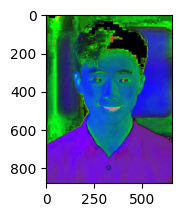

hue:46.524652203856746,saturation:76.45362947658403,value:121.66589876033058
开始压缩图片：xhs.jpeg
压缩之后:
hue:46.47726124885216,saturation:76.30998622589532,value:121.582782369146


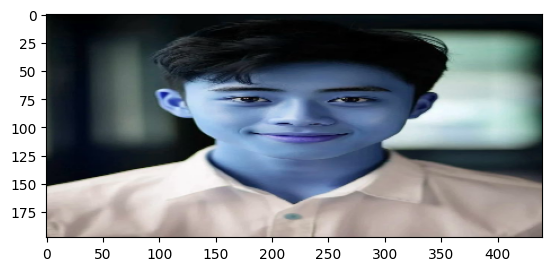

压缩完毕：xhs.jpeg
读取完毕：xhs.jpeg
开始捕捉摄像头实时图像：
这是一张室内场景照片。近处有一位戴着眼镜、留着中长发、身穿浅色上衣的人物。背景中可以看到几位正在活动的人，其中一人面前放着笔记本电脑和红色杯子等物品，似乎在专注工作或学习。墙上有一个电子时钟显示时间为14:14，旁边有摄像头等设备，窗户外面是葱郁的树木，整体氛围显得安静且日常。 
这张图片整体较暗。前景中能看到一位戴着眼镜、留着黑色长发的人物。背景里是一个室内场景，有几扇大窗户，窗外可见枝叶繁茂的绿树；室内似乎还有其他人在活动，天花板上安装着条状的白色灯具，墙上有一个显示时间为14:14的电子钟，整体氛围安静，像是在图书馆或自习室等场所 。
达到最大读取次数，摄像头图像捕捉结束
图像处理完毕


In [9]:
if __name__ == '__main__':
    file_path = 'xhs.jpeg'
    img_process(file_path)
    # 调用程序
    main()